In [35]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_excel('AirQualityUCI.xlsx')
df.head()


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [ ]:
# Replace -200 with NaN
df = df.replace(-200, np.nan)

# Combine Date and Time columns
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')

# Drop rows with invalid datetime
df = df.dropna(subset=['Datetime'])

# Set Datetime as index
df = df.set_index('Datetime')

# Drop original Date, Time columns
df = df.drop(['Date', 'Time'], axis=1)

# Check missing values
df.isna().sum().sort_values(ascending=False)


NMHC(GT)         8443
CO(GT)           1683
NO2(GT)          1642
NOx(GT)          1639
PT08.S1(CO)       366
PT08.S2(NMHC)     366
C6H6(GT)          366
PT08.S3(NOx)      366
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [5]:
# Simple imputation
df = df.interpolate(method='time')


In [6]:
df.describe()


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,2.130603,1102.932925,269.834349,10.178838,942.019562,241.908464,832.634930,109.620033,1453.172887,1032.422456,18.231754,49.189157,1.019621
std,1.431736,218.201561,74.251999,7.503295,267.864854,204.308147,255.708807,46.451523,343.201361,404.442611,8.782368,17.194081,0.402203
min,0.100000,647.250000,7.000000,0.149048,383.250000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.175000,0.184679
25%,1.100000,937.500000,275.000000,4.477145,736.000000,96.000000,654.000000,76.000000,1227.000000,733.250000,11.725000,35.800000,0.732280
50%,1.800000,1066.750000,275.000000,8.289085,910.333333,180.000000,803.500000,104.827586,1459.500000,970.000000,17.575000,49.650000,0.989504
75%,2.900000,1238.750000,275.000000,14.096486,1119.000000,326.000000,967.500000,136.400000,1668.250000,1293.000000,24.275001,62.250002,1.306671
max,11.900000,2039.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,88.725000,2.231036


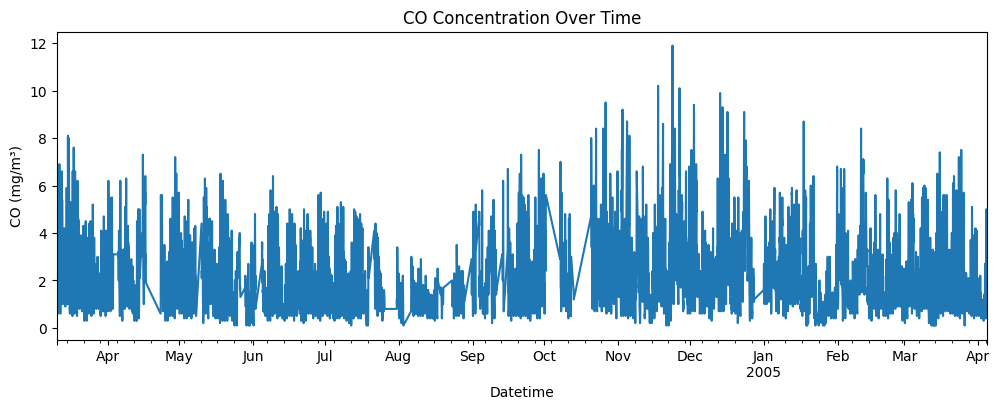

In [7]:
import matplotlib.pyplot as plt

df['CO(GT)'].plot(figsize=(12,4), title='CO Concentration Over Time')
plt.ylabel('CO (mg/m³)')
plt.show()


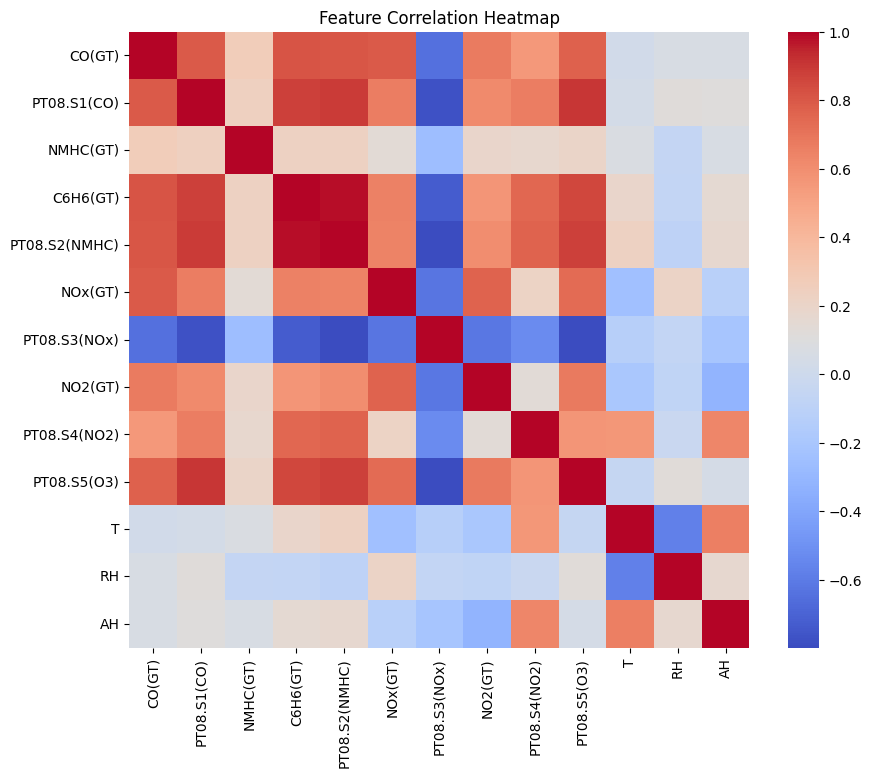

In [8]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()


<Axes: xlabel='hour', ylabel='CO(GT)'>

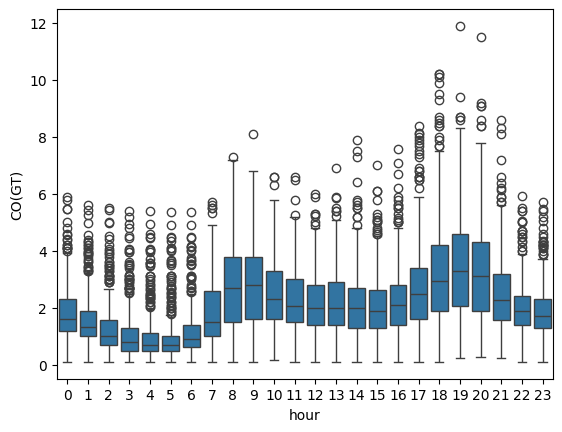

In [9]:
df['hour'] = df.index.hour
sns.boxplot(x='hour', y='CO(GT)', data=df)


In [ ]:
#feature engineering
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['CO_roll3'] = df['CO(GT)'].rolling(window=3).mean().shift(1)
df = df.dropna()


In [11]:
from sklearn.model_selection import train_test_split

X = df.drop('CO(GT)', axis=1)
y = df['CO(GT)']

# Split chronologically
split = int(len(df)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")


MAE: 0.387, RMSE: 0.558, R²: 0.837


In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, pred)),  # manual RMSE calculation
    'R2': r2_score(y_test, pred)
    }

pd.DataFrame(results).T


,MAE,RMSE,R2
Linear Regression,0.386670,0.558474,0.836505
Random Forest,0.368428,0.558055,0.836750
Gradient Boosting,0.413561,0.567649,0.831089
AdaBoost,0.716748,0.842806,0.627648


In [ ]:
# Model Tuning (Example: Random Forest)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


tscv = TimeSeriesSplit(n_splits=5)
params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), params, cv=tscv, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)

print(grid.best_params_)

# The best model from GridSearchCV
best_model = grid.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Tuned Random Forest Performance:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [23]:
print(f"Tuned Random Forest Performance:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

Tuned Random Forest Performance:
MAE: 0.369
RMSE: 0.557
R²: 0.837


In [24]:
#Tune Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

params_gb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

grid_gb = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    params_gb,
    cv=tscv,
    scoring='neg_mean_absolute_error'
)

grid_gb.fit(X_train, y_train)

print("Best Gradient Boosting Params:", grid_gb.best_params_)

# Evaluate
best_gb = grid_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred_gb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))  # manually take sqrt
r2 = r2_score(y_test, y_pred_gb)

print("Tuned Gradient Boosting Performance:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")




Best Gradient Boosting Params: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Tuned Gradient Boosting Performance:
MAE: 0.369
RMSE: 0.560
R²: 0.836


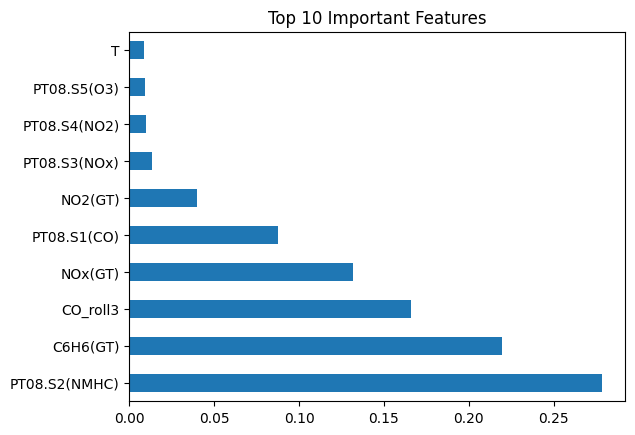

In [25]:
best_model = grid.best_estimator_
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(10).plot(kind='barh')
plt.title('Top 10 Important Features')
plt.show()


In [26]:
import joblib
joblib.dump(best_model, 'air_quality_model.pkl')


['air_quality_model.pkl']

In [31]:
import pandas as pd

# Model performances
model_results = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'AdaBoost'],
    'MAE': [0.386670, 0.368428, 0.413561, 0.716748],
    'RMSE': [0.558474, 0.558055, 0.567649, 0.842806],
    'R2': [0.836505, 0.836750, 0.831089, 0.627648]
}

df_results = pd.DataFrame(model_results)
print("=== Model Comparison ===")
print(df_results)

# Tuned models
tuned_results = {
    'Model': ['Tuned Gradient Boosting', 'Tuned Random Forest'],
    'MAE': [0.369, 0.369],
    'RMSE': [0.560, 0.557],
    'R2': [0.836, 0.837]
}

df_tuned = pd.DataFrame(tuned_results)
print("\n=== Tuned Model Performance ===")
print(df_tuned)


=== Model Comparison ===
               Model       MAE      RMSE        R2
0  Linear Regression  0.386670  0.558474  0.836505
1      Random Forest  0.368428  0.558055  0.836750
2  Gradient Boosting  0.413561  0.567649  0.831089
3           AdaBoost  0.716748  0.842806  0.627648

=== Tuned Model Performance ===
                     Model    MAE   RMSE     R2
0  Tuned Gradient Boosting  0.369  0.560  0.836
1      Tuned Random Forest  0.369  0.557  0.837


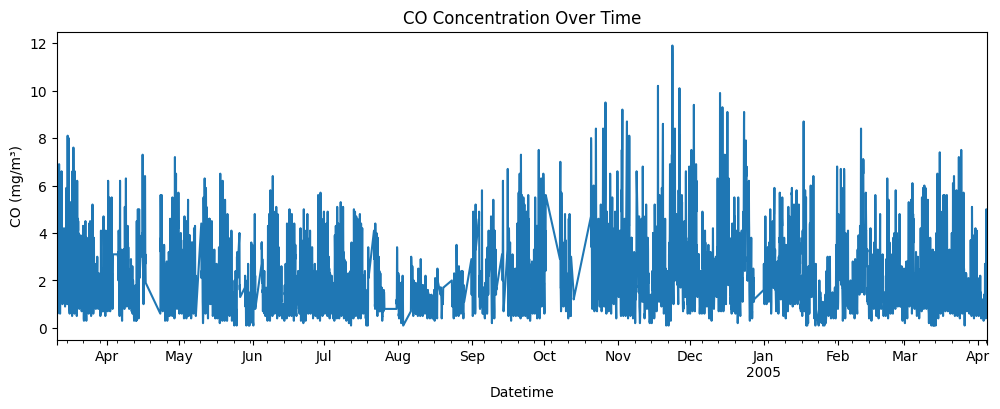

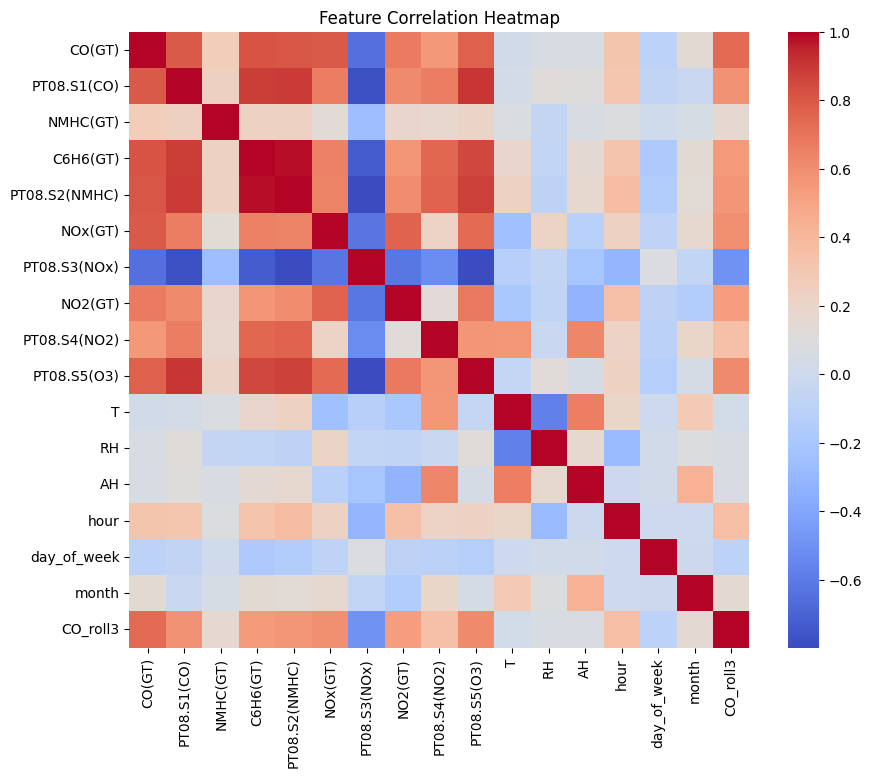

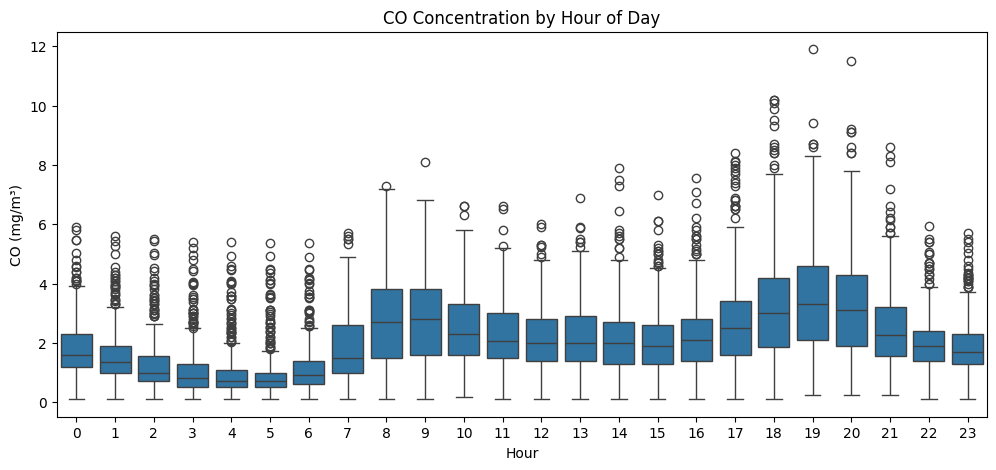

=== Model Comparison ===
                        MAE      RMSE        R2
Linear Regression  0.386670  0.558474  0.836505
Random Forest      0.368428  0.558055  0.836750
Gradient Boosting  0.413561  0.567649  0.831089
AdaBoost           0.743585  0.864675  0.608074

Tuned Gradient Boosting Performance:
MAE: 0.369
RMSE: 0.560
R²: 0.836
Best Gradient Boosting Params: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}

Tuned Random Forest Performance:
MAE: 0.368
RMSE: 0.557
R²: 0.837


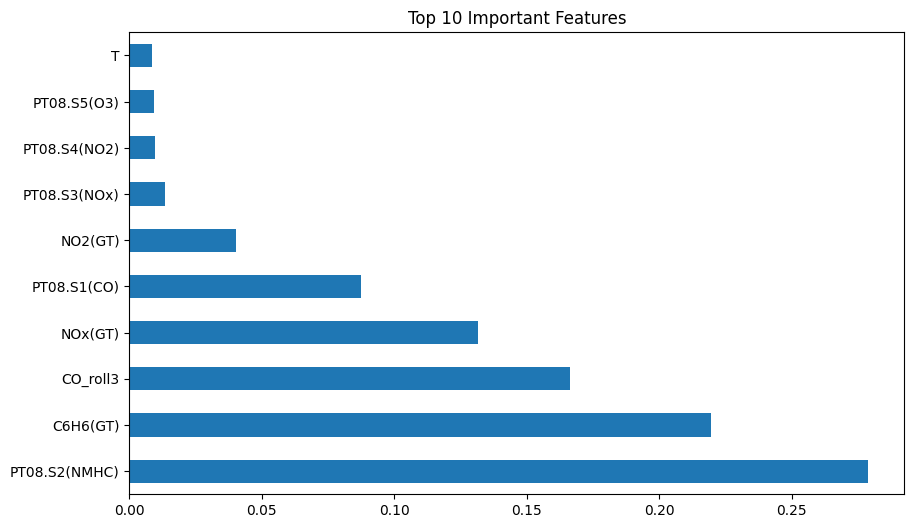


Model saved as 'air_quality_model.pkl'.


In [1]:
# air_quality_project.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# -----------------------
# 1. Load Data
# -----------------------

# Load dataset
df = pd.read_excel('AirQualityUCI.xlsx')
df.head()
# Initial Cleaning
df = df.dropna(axis=1, how='all')
df = df.replace(-200, np.nan)

# Combine Date and Time into Datetime
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')
df = df.dropna(subset=['Datetime'])
df = df.set_index('Datetime')
df = df.drop(['Date', 'Time'], axis=1)

# -----------------------
# 2. Handle Missing Values
# -----------------------
df = df.interpolate(method='time')

# -----------------------
# 3. Feature Engineering
# -----------------------
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['CO_roll3'] = df['CO(GT)'].rolling(window=3).mean().shift(1)
df = df.dropna()

# -----------------------
# 4. EDA
# -----------------------
# 4.1 CO over time
plt.figure(figsize=(12,4))
df['CO(GT)'].plot(title='CO Concentration Over Time')
plt.ylabel('CO (mg/m³)')
plt.show()

# 4.2 Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# 4.3 Boxplot CO vs Hour
plt.figure(figsize=(12,5))
sns.boxplot(x='hour', y='CO(GT)', data=df)
plt.title('CO Concentration by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('CO (mg/m³)')
plt.show()

# -----------------------
# 5. Prepare Data for Modeling
# -----------------------
X = df.drop('CO(GT)', axis=1)
y = df['CO(GT)']

# Time-based split
split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# -----------------------
# 6. Train & Compare Models
# -----------------------
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, pred)),
        'R2': r2_score(y_test, pred)
    }

df_results = pd.DataFrame(results).T
print("=== Model Comparison ===")
print(df_results)

# -----------------------
# 7. Hyperparameter Tuning: Gradient Boosting
# -----------------------
tscv = TimeSeriesSplit(n_splits=5)
params = {
    'n_estimators': [200],
    'max_depth': [10],
    'learning_rate': [0.05],
    'subsample': [0.8]
}

gb = GradientBoostingRegressor(random_state=42)
grid = GridSearchCV(gb, params, cv=tscv, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)

best_gb = grid.best_estimator_
y_pred_gb = best_gb.predict(X_test)
print("\nTuned Gradient Boosting Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_gb):.3f}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2_score(y_test, y_pred_gb):.3f}")
print(f"Best Gradient Boosting Params: {grid.best_params_}")

# -----------------------
# 8. Hyperparameter Tuning: Random Forest (optional)
# -----------------------
rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nTuned Random Forest Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.3f}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2_score(y_test, y_pred_rf):.3f}")

# -----------------------
# 9. Feature Importance (Random Forest)
# -----------------------
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
importances.head(10).plot(kind='barh')
plt.title('Top 10 Important Features')
plt.show()


# Save feature columns
feature_columns = X_train.columns.tolist()
joblib.dump(feature_columns, 'feature_columns.pkl')

# Save model
joblib.dump(rf, 'air_quality_model.pkl')

# -----------------------
# 10. Save Best Model
# -----------------------
joblib.dump(rf, 'air_quality_model.pkl')
print("\nModel saved as 'air_quality_model.pkl'.")



In [2]:
import requests

url = "http://localhost:5000/predict"
data = {
    "PT08.S1(CO)":1360,"PT08.S2(NMHC)":1046,"PT08.S3(NOx)":1056,
    "PT08.S4(NO2)":1692,"PT08.S5(O3)":1268,"NMHC(GT)":150,"C6H6(GT)":11.9,
    "NOx(GT)":166,"NO2(GT)":113,"T":13.6,"RH":48.9,"AH":0.7578,
    "hour":18,"day_of_week":2,"month":3,"CO_roll3":2.2
}

response = requests.post(url, json=data)
print(response.json())


{'error': 'The feature names should match those that were passed during fit.\nFeature names must be in the same order as they were in fit.\n'}
